In [1]:
import os
import cv2
import random
import time 

import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.models import *


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2024-02-21 14:55:17.353751: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 14:55:17.353854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 14:55:17.491829: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
len(os.listdir('/kaggle/input/brain-tumor-mri-images-44c/'))

44

In [5]:
data_path= "/kaggle/input/brain-tumor-mri-images-44c"

In [6]:
df = pd.DataFrame(columns=['path','label'])

In [7]:
folder = os.listdir(data_path)
def create_df(df):
    for fold in folder:
        class_path = os.path.join(data_path,fold)
        class_folder = os.listdir(class_path)
        for img in class_folder:
            img_path = os.path.join(class_path,img)
            df = df._append({'path':os.path.join(class_path,img) , 'label' : fold.split(' ')[0]},ignore_index=True)
    return df

In [8]:
df = create_df(df)
df.head()

,path,label
0,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma
1,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma
2,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma
3,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma
4,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma


In [9]:
label_counts = df['label'].value_counts().sort_values(ascending=False)
sorted_label = label_counts.index

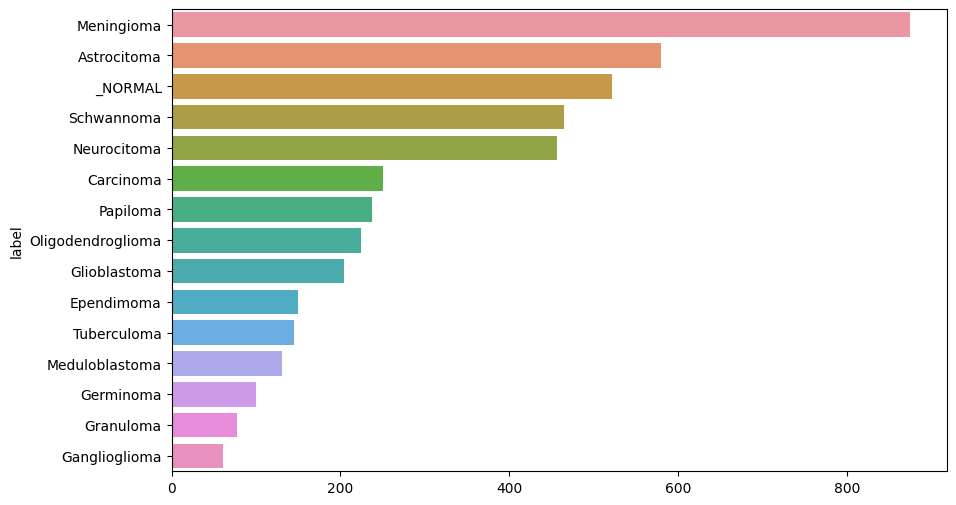

In [10]:
plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.values, y=sorted_label)
plt.show()